In [1]:
import pickle
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('modified_data_temp_df.csv', index_col=0)
data

,T-1,T-24,H-1,H-24,Season,T
0,62.0,65.0,89.0,90.0,1.0,65.0
1,65.0,65.0,90.0,90.0,1.0,65.0
2,65.0,65.0,90.0,90.0,1.0,65.0
3,65.0,78.0,90.0,49.0,1.0,78.0
4,78.0,78.0,48.0,49.0,1.0,78.0
...,...,...,...,...,...,...
8731,67.0,69.0,92.0,88.0,1.0,67.0
8732,67.0,69.0,92.0,88.0,1.0,67.0
8733,67.0,65.0,92.0,94.0,1.0,65.0
8734,65.0,65.0,94.0,94.0,1.0,65.0


In [3]:
x_data = data[data.columns[:5]]
x_data

,T-1,T-24,H-1,H-24,Season
0,62.0,65.0,89.0,90.0,1.0
1,65.0,65.0,90.0,90.0,1.0
2,65.0,65.0,90.0,90.0,1.0
3,65.0,78.0,90.0,49.0,1.0
4,78.0,78.0,48.0,49.0,1.0
...,...,...,...,...,...
8731,67.0,69.0,92.0,88.0,1.0
8732,67.0,69.0,92.0,88.0,1.0
8733,67.0,65.0,92.0,94.0,1.0
8734,65.0,65.0,94.0,94.0,1.0


In [4]:
y_data = data[['T']]
y_data

,T
0,65.0
1,65.0
2,65.0
3,78.0
4,78.0
...,...
8731,67.0
8732,67.0
8733,65.0
8734,65.0


In [5]:
from sklearn.preprocessing import MinMaxScaler

x_scalar = MinMaxScaler()
x_scalar.fit(x_data)
x_data_scaled = x_scalar.fit_transform(x_data)
x_data_scaled

array([[0.20689655, 0.25862069, 0.85227273, 0.86363636, 0.5       ],
       [0.25862069, 0.25862069, 0.86363636, 0.86363636, 0.5       ],
       [0.25862069, 0.25862069, 0.86363636, 0.86363636, 0.5       ],
       ...,
       [0.29310345, 0.25862069, 0.88636364, 0.90909091, 0.5       ],
       [0.25862069, 0.25862069, 0.90909091, 0.90909091, 0.5       ],
       [0.25862069, 0.25862069, 0.90909091, 0.90909091, 0.5       ]])

In [6]:
y_scalar = MinMaxScaler()
y_scalar.fit(y_data)
y_data_scaled = y_scalar.fit_transform(y_data)
y_data_scaled

array([[0.25862069],
       [0.25862069],
       [0.25862069],
       ...,
       [0.25862069],
       [0.25862069],
       [0.25862069]])

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_data_scaled, y_data_scaled, test_size=0.33, random_state=42)

In [8]:
from sklearn.cluster import KMeans
import joblib as jbl
import numpy as np
import tensorflow as tf

class RBFNet:
    def __init__(self, X, y, X_test, y_test, n_hidden_neurons, width_factor) -> None:
        self.X = X
        self.y = y
        self.X_test = X_test
        self.y_test = y_test
        self.n_hidden = n_hidden_neurons
        self.p = width_factor
        
        self._centroids = None
        self._sigma_mat = None
        self._out_mat = None
        self._out_mat_test = None
        
    def KMeans(self):
        km = KMeans(n_clusters=self.n_hidden).fit(self.X, self.y)
        self._centroids = km.cluster_centers_
        jbl.dump(km, "kmeans.jbl")
        
    def gaussian_rbf(self):
        
        def get_min_indices(x, n=2):
            min_values = np.sort(x)[:n]
            return np.array([np.where(x == i)[0][0] for i in min_values])
        
        distance_mat = np.zeros((self.n_hidden, self.n_hidden))
        sigma_mat = np.zeros(self.n_hidden)
        
        # distance matrix calculation
        for i in range(self.n_hidden):
            for j in range(self.n_hidden):
                distance_mat[i][j] = np.linalg.norm(self._centroids[i] - self._centroids[j])
                distance_mat[j][i] = distance_mat[i][j]
                
        # calculating sigma matrix
        for i in range(self.n_hidden):
            x = distance_mat[i]
            min_indices = get_min_indices(x, self.p)
            
            ED_array = np.zeros(self.p-1)
            
            for j in range(len(ED_array)):
                ED_array[j] = np.linalg.norm(self._centroids[i] - self._centroids[min_indices[j+1]])
            sigma_mat[i] = np.sqrt(np.square(ED_array).sum() / self.p)
            
        self._sigma_mat = sigma_mat
        self._out_mat = self.out_matrix(self.X, self.n_hidden, self._centroids, self._sigma_mat)
        self._out_mat_test = self.out_matrix(self.X_test, self.n_hidden, self._centroids, self._sigma_mat)
                
    def out_matrix(self, X, n_hidden, centroids, sigma_mat):
        out_mat = np.zeros((X.shape[0], n_hidden))
        for i in range(len(X)):
            for j in range(n_hidden):
                numerator = -np.square(X[i] - centroids[j]).sum()
                denominator = 2*(np.square(sigma_mat[j]))
                out_mat[i][j] = np.exp(numerator/denominator)
        return out_mat

In [9]:
rbf = RBFNet(X=X_train,
             y=y_train,
             X_test=X_test,
             y_test=y_test,
             n_hidden_neurons=4,
             width_factor=2)

In [10]:
rbf.KMeans()

In [11]:
rbf._centroids

array([[ 5.53207920e-01,  5.53962827e-01,  7.17550442e-01,
         7.18276753e-01, -1.38777878e-15],
       [ 5.57300603e-01,  5.57189904e-01,  6.31384065e-01,
         6.32049832e-01,  1.00000000e+00],
       [ 3.56353073e-01,  3.57865710e-01,  7.48173701e-01,
         7.41397868e-01,  5.00388199e-01],
       [ 6.83351455e-01,  6.77513721e-01,  2.83143939e-01,
         2.85515629e-01,  7.70270270e-01]])

In [12]:
rbf.gaussian_rbf()

In [13]:
rbf._out_mat.shape

(5853, 4)

In [14]:
out_mat = rbf._out_mat
out_mat_test = rbf._out_mat_test

In [15]:
out_mat_test.shape

(2883, 4)

In [16]:
x_test_ann = rbf._out_mat_test
x_train_ann = rbf._out_mat

In [17]:
Sequential = tf.keras.Sequential
Dense = tf.keras.layers.Dense

In [18]:
model = Sequential([
    Dense(1, input_shape=(4, ), activation='linear')
])

model.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


2023-02-25 09:52:20.616781: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-25 09:52:20.616909: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [19]:
model.compile(tf.optimizers.Adam(learning_rate=0.1), loss=tf.losses.MeanSquaredError(), metrics=['mae'])

In [20]:
model.fit(x=x_train_ann, y=y_train, validation_data=(x_test_ann, y_test), epochs=100)

Epoch 1/100


2023-02-25 09:52:20.842464: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 10/183 [>.............................] - ETA: 0s - loss: 0.2609 - mae: 0.4183  

2023-02-25 09:52:21.059634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


183/183 [==============================] - ETA: 0s - loss: 0.0253 - mae: 0.0984

2023-02-25 09:52:22.370217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


183/183 [==============================] - 2s 8ms/step - loss: 0.0253 - mae: 0.0984 - val_loss: 0.0083 - val_mae: 0.0695
Epoch 2/100
183/183 [==============================] - 1s 7ms/step - loss: 0.0083 - mae: 0.0701 - val_loss: 0.0087 - val_mae: 0.0718
Epoch 3/100
183/183 [==============================] - 1s 7ms/step - loss: 0.0083 - mae: 0.0698 - val_loss: 0.0086 - val_mae: 0.0726
Epoch 4/100
183/183 [==============================] - 2s 10ms/step - loss: 0.0086 - mae: 0.0716 - val_loss: 0.0083 - val_mae: 0.0696
Epoch 5/100
183/183 [==============================] - 2s 9ms/step - loss: 0.0090 - mae: 0.0738 - val_loss: 0.0082 - val_mae: 0.0684
Epoch 6/100
183/183 [==============================] - 2s 11ms/step - loss: 0.0086 - mae: 0.0716 - val_loss: 0.0090 - val_mae: 0.0728
Epoch 7/100
183/183 [==============================] - 1s 7ms/step - loss: 0.0085 - mae: 0.0713 - val_loss: 0.0087 - val_mae: 0.0712
Epoch 8/100
183/183 [==============================] - 1s 7ms/step - loss: 0.00

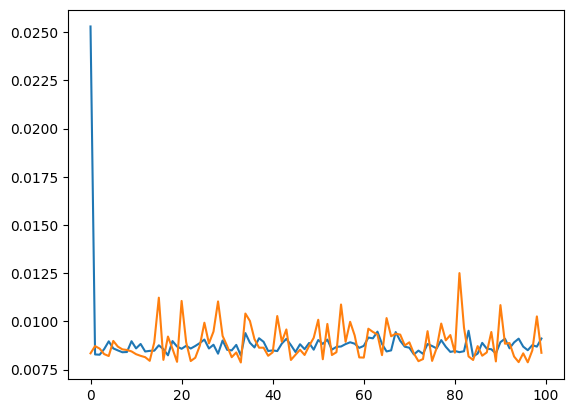

In [21]:
import matplotlib.pyplot as plt

plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])

In [22]:
y_test

array([[0.46551724],
       [0.46551724],
       [0.62068966],
       ...,
       [0.72413793],
       [0.51724138],
       [0.63793103]])

In [23]:
y_pred_test = model.predict(x_test_ann)

91/91 [==============================] - 0s 2ms/step


2023-02-25 09:54:40.107125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [24]:
y_pred_test

array([[0.53255856],
       [0.53854793],
       [0.5897487 ],
       ...,
       [0.7288152 ],
       [0.50075704],
       [0.55057335]], dtype=float32)

In [25]:
y_pred_unscaled = y_scalar.inverse_transform(y_pred_test)
y_pred_unscaled

array([[80.8884  ],
       [81.23578 ],
       [84.20542 ],
       ...,
       [92.271286],
       [79.04391 ],
       [81.93326 ]], dtype=float32)

In [26]:
y_test_unscaled = y_scalar.inverse_transform(y_test)
y_test_unscaled

array([[77.],
       [77.],
       [86.],
       ...,
       [92.],
       [80.],
       [87.]])

In [27]:
pd.DataFrame(data={
    "y_test" : list(y_test_unscaled),
    "y_pred" : list(y_pred_unscaled)
})

,y_test,y_pred
0,[77.0],[80.8884]
1,[77.0],[81.23578]
2,[86.0],[84.20542]
3,[71.0],[67.35344]
4,[70.0],[76.61087]
...,...,...
2878,[81.0],[85.148605]
2879,[104.0],[89.77367]
2880,[92.0],[92.271286]
2881,[80.0],[79.04391]


In [28]:
i = 5675
print(y_train[i])
single_pred = model.predict(rbf._out_mat[i].reshape((1, 4)))[0][0]
single_pred

[0.48275862]
1/1 [==============================] - 0s 22ms/step


0.3278119

In [29]:
y_scalar.inverse_transform([[single_pred]])

array([[69.01309001]])

In [30]:
actual = y_scalar.inverse_transform([[y_train[i][0]]])
predicted = y_scalar.inverse_transform([[single_pred]])

print(f"""
      Actual: {actual}
      Predicted: {predicted}
      """)


      Actual: [[78.]]
      Predicted: [[69.01309001]]
      


In [31]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, y_pred_test)

0.00837106302402647

## Predicting on unseen data

In [32]:
data

,T-1,T-24,H-1,H-24,Season,T
0,62.0,65.0,89.0,90.0,1.0,65.0
1,65.0,65.0,90.0,90.0,1.0,65.0
2,65.0,65.0,90.0,90.0,1.0,65.0
3,65.0,78.0,90.0,49.0,1.0,78.0
4,78.0,78.0,48.0,49.0,1.0,78.0
...,...,...,...,...,...,...
8731,67.0,69.0,92.0,88.0,1.0,67.0
8732,67.0,69.0,92.0,88.0,1.0,67.0
8733,67.0,65.0,92.0,94.0,1.0,65.0
8734,65.0,65.0,94.0,94.0,1.0,65.0


making predictions using the already computed sigma and centers matrix

In [33]:
centers = rbf._centroids
sigma = rbf._sigma_mat
n_hidden = rbf.n_hidden

In [34]:
inputs = np.array([65, 67, 90, 87, 1])
out_mat_pred = rbf.out_matrix(X=inputs,
               n_hidden=n_hidden,
               centroids=centers,
               sigma_mat=sigma)

In [35]:
out_mat_pred[-1]

array([0.00879346, 0.12948907, 0.02556591, 0.01927626])

In [36]:
single_pred = model.predict(out_mat_pred[-1].reshape((1, 4)))
single_pred

1/1 [==============================] - 0s 14ms/step


array([[0.57508546]], dtype=float32)

In [37]:
y_scalar.inverse_transform([[single_pred[0][0]]])

array([[83.35495675]])